# How to use Autopycoin

This notebook is a quick start for autopycoin. We will demonstrate its efficiency through a toy example.

## Import

As our package is based on tensorflow we need to import it.

In [44]:
import tensorflow as tf

Let's create our data thanks to `random_ts` which generate a fake time serie based on a trend and seasonality components.

Text(0.5, 1.0, 'Generated data')

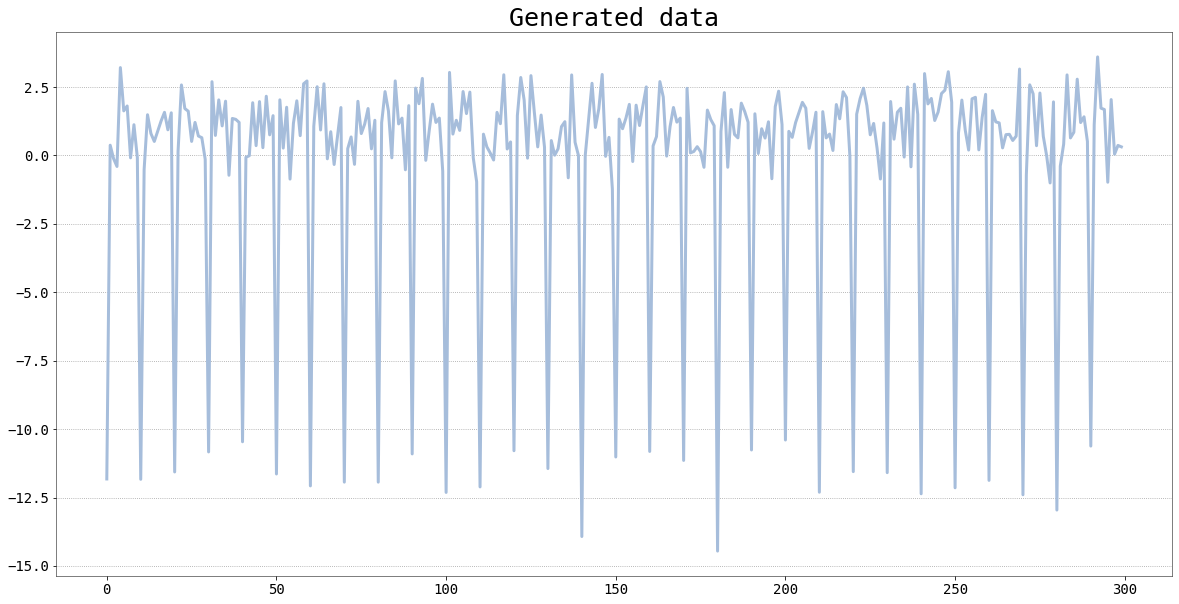

In [45]:
from autopycoin.autopycoin.data import random_ts

data = random_ts(n_steps=300, # Number of steps (second dimension)
                 trend_degree=2,
                 periods=[10], # We can combine multiple periods, period is the time length for a cyclical function to reproduce a similar output
                 fourier_orders=[10], # higher is this number, more complex is the output
                 trend_mean=0,
                 trend_std=1,
                 seasonality_mean=0,
                 seasonality_std=1, 
                 batch_size=1, # Generate a batch of data (first dimension)
                 n_variables=1, # Number of variables (last dimension)
                 noise=True, # add normal centered noise
                 seed=42)

# Let's render it with matplotlib
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 10)
plt.plot(data[0])
plt.title('Generated data')

# Tensorflow library

Tensorflow use `dataset` to feed its models. Hence, we create an object `WindowGenerator` to facilitate the creation of training, validation and training set.

In [46]:
from autopycoin.autopycoin.dataset import WindowGenerator

We first create an instance of `Windowgenerator` by defining important parameters value.
By defining an `input_width` of 70, we set our input length.
 - `label_width` set our label length.
 - `shift` represents the shift between label and input data. Hence if you don't want label and input overlapping `shift` has to be equal to   `label_width`. It can help for more complex model like lstm models which can be trained to reconstruct their inputs.
 - `test_size` and `valid_size` are the numbers of examples to predict. If they are integer, they are the true number of examples, if they are float then it's a proportion of the entire data.

Note: We create lot of examples by shifting by one the window of prediction.

In [47]:
w = WindowGenerator(
        input_width=70,
        label_width=10,
        shift=10,
        test_size=50,
        valid_size=10,
        flat=True,
        batch_size=32,
    )

We can't use it now as it needs to be initialized by an array, tensor or a dataframe

In [48]:
w = w.from_array(data=data[0], # Has to be 2D array
        input_columns=[0],
        known_columns=[],
        label_columns=[0],
        date_columns=[],)

# Or using dataframe
import pandas as pd

data = pd.DataFrame(data[0], columns=['test'])

w = w.from_dataframe(data=data, # Has to be 2D array
        input_columns=['test'],
        known_columns=[],
        label_columns=['test'],
        date_columns=[],)

In [49]:
w.train

<PrefetchDataset shapes: (((None, 70), (None, 70), (None, 10)), (None, 10)), types: ((tf.float32, tf.string, tf.string), tf.float32)>

In [50]:
w.valid

<PrefetchDataset shapes: (((None, 70), (None, 70), (None, 10)), (None, 10)), types: ((tf.float32, tf.string, tf.string), tf.float32)>

In [51]:
w.test

<PrefetchDataset shapes: (((None, 70), (None, 70), (None, 10)), (None, 10)), types: ((tf.float32, tf.string, tf.string), tf.float32)>

# It's time for inference

We import the nbeats module where the nbdeats model is defined.

There are currently multiple version of nbeats implemented as `create_interpretable_nbeats` or `create_generic_nbeats`.
But it is possible to customize it's own nbeats model by subclassing the nbeats Model and Layer.

In [52]:
from autopycoin.autopycoin.models import nbeats

model1 = nbeats.create_interpretable_nbeats(
            input_width=70,
            label_width=10,
            forecast_periods=[20],
            backcast_periods=[10],
            forecast_fourier_order=[20],
            backcast_fourier_order=[10],
            p_degree=2,
            trend_n_neurons=32,
            seasonality_n_neurons=32,
            drop_rate=0.,
            share=True)

model1.compile(tf.keras.optimizers.Adam(
    learning_rate=0.015, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True,
    name='Adam'), loss='mse', metrics=["mae"])

model1.fit(w.train, validation_data=w.valid, epochs=10)

Epoch 1/10
5/5 [==============================] - 1s 72ms/step - loss: 609.1262 - mae: 16.3543 - val_loss: 42.8115 - val_mae: 5.2306
Epoch 2/10
5/5 [==============================] - 0s 33ms/step - loss: 46.1997 - mae: 5.2535 - val_loss: 33.3035 - val_mae: 4.6255
Epoch 3/10
5/5 [==============================] - 0s 27ms/step - loss: 27.4149 - mae: 3.8155 - val_loss: 16.8427 - val_mae: 3.0753
Epoch 4/10
5/5 [==============================] - 0s 28ms/step - loss: 15.6920 - mae: 2.8927 - val_loss: 13.4909 - val_mae: 2.7274
Epoch 5/10
5/5 [==============================] - 0s 27ms/step - loss: 12.7343 - mae: 2.4994 - val_loss: 11.6184 - val_mae: 2.6963
Epoch 6/10
5/5 [==============================] - 0s 27ms/step - loss: 11.0554 - mae: 2.4979 - val_loss: 8.2103 - val_mae: 2.0675
Epoch 7/10
5/5 [==============================] - 0s 27ms/step - loss: 8.6995 - mae: 2.1904 - val_loss: 7.1853 - val_mae: 1.9954
Epoch 8/10
5/5 [==============================] - 0s 27ms/step - loss: 7.0314 - mae:

In [53]:
from autopycoin.autopycoin.models import nbeats

model2 = nbeats.create_generic_nbeats(
            input_width=70,
            label_width=10,
            forecast_neurons=16, 
            backcast_neurons=16, 
            n_neurons=16, 
            n_blocks=3,
            n_stacks=2,
            drop_rate=0.1,
            share=True)

model2.compile(tf.keras.optimizers.Adam(
    learning_rate=0.015, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True,
    name='Adam'), loss='mse', metrics=["mae"])

model2.fit(w.train, validation_data=w.valid, epochs=10)

Epoch 1/10
5/5 [==============================] - 2s 132ms/step - loss: 24.6151 - mae: 3.2837 - val_loss: 13.7818 - val_mae: 2.4562
Epoch 2/10
5/5 [==============================] - 0s 48ms/step - loss: 12.5529 - mae: 2.2549 - val_loss: 9.9439 - val_mae: 2.1067
Epoch 3/10
5/5 [==============================] - 0s 48ms/step - loss: 10.2437 - mae: 2.1768 - val_loss: 8.7786 - val_mae: 2.0562
Epoch 4/10
5/5 [==============================] - 0s 45ms/step - loss: 8.4095 - mae: 2.0142 - val_loss: 8.7424 - val_mae: 2.0903
Epoch 5/10
5/5 [==============================] - 0s 46ms/step - loss: 7.0130 - mae: 1.8984 - val_loss: 6.1092 - val_mae: 1.8009
Epoch 6/10
5/5 [==============================] - 0s 42ms/step - loss: 5.7844 - mae: 1.7769 - val_loss: 5.1711 - val_mae: 1.6976
Epoch 7/10
5/5 [==============================] - 0s 43ms/step - loss: 4.7211 - mae: 1.6507 - val_loss: 4.4949 - val_mae: 1.6572
Epoch 8/10
5/5 [==============================] - 0s 44ms/step - loss: 3.7415 - mae: 1.4662 

# Evaluation

In [54]:
model1.evaluate(w.test)

2/2 [==============================] - 0s 8ms/step - loss: 5.4553 - mae: 1.8062


[5.4552903175354, 1.8062074184417725]

In [55]:
model2.evaluate(w.test)

2/2 [==============================] - 0s 12ms/step - loss: 3.2848 - mae: 1.4062


[3.2848401069641113, 1.4062144756317139]

# Plot

Let plot some previsions

In [56]:
from autopycoin.autopycoin.display import ShowTs

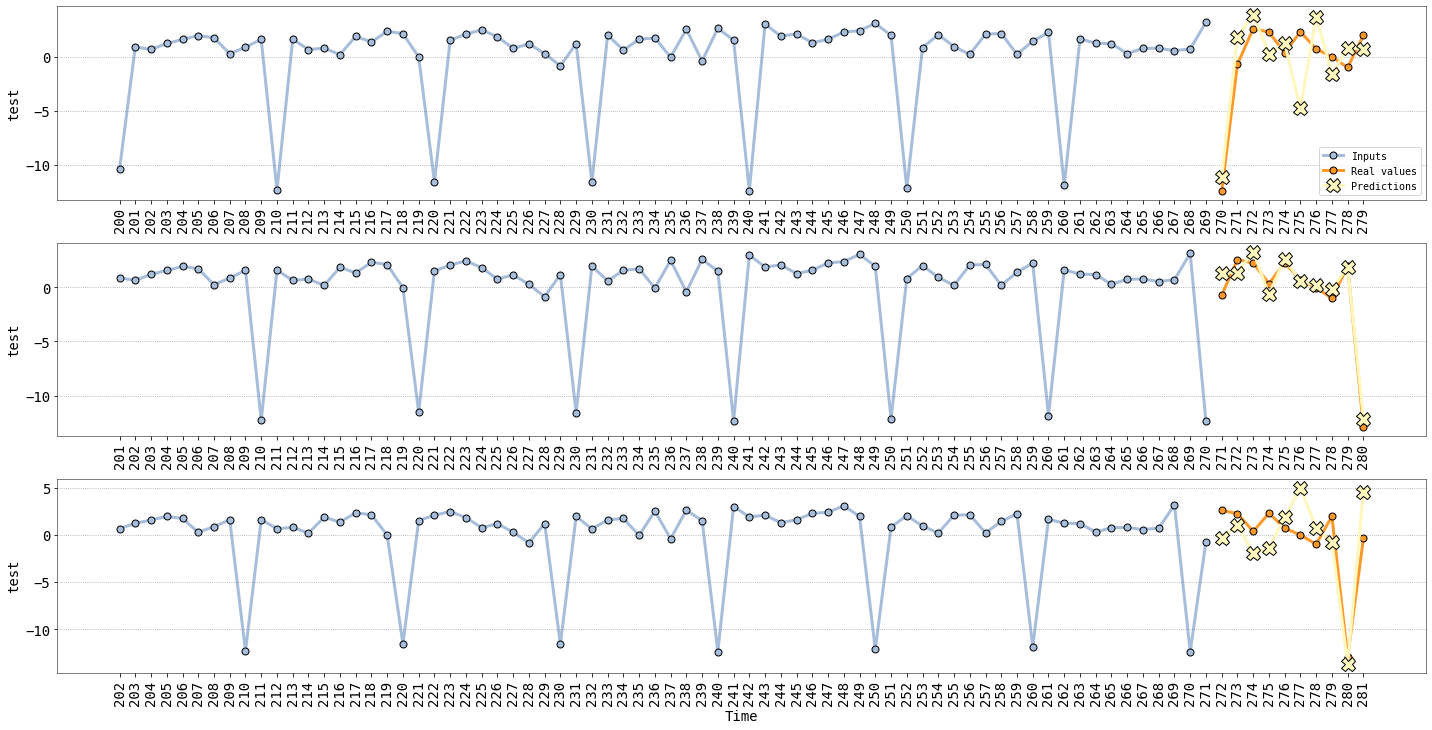

In [29]:
plotter = ShowTs(w, 'test', model1)

plotter.plot_from_index('270', 'test')

# Production

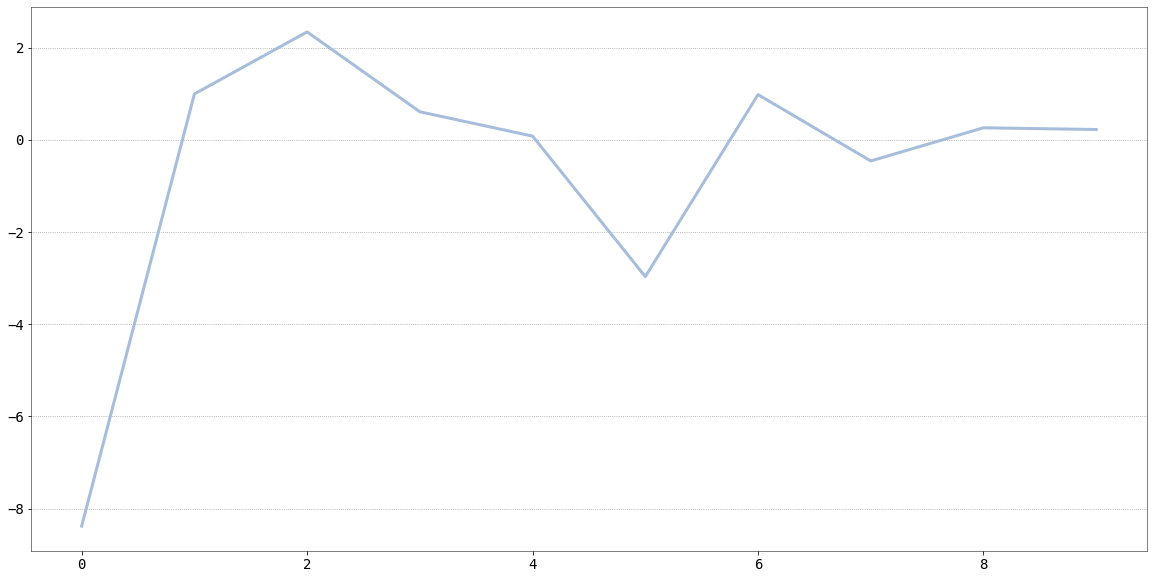

In [30]:
prod = w.production(data)
plt.plot(model1.predict(prod)[0])

# A pool is better than a single model

In [63]:
from autopycoin.autopycoin.models import PoolNBEATS
from autopycoin.autopycoin.losses import QuantileLossError, SymetricMeanAbsolutePercentageError
import tensorflow_probability as tfp


data = random_ts(n_steps=300, # Number of steps (second dimension)
                 trend_degree=2,
                 periods=[10], # We can combine multiple periods, period is the time length for a cyclical function to reproduce a similar output
                 fourier_orders=[10], # higher is this number, more complex is the output
                 trend_mean=0,
                 trend_std=1,
                 seasonality_mean=0,
                 seasonality_std=1, 
                 batch_size=1, # Generate a batch of data (first dimension)
                 n_variables=1, # Number of variables (last dimension)
                 noise=True, # add normal centered noise
                 seed=42)


w = WindowGenerator(
        input_width=70,
        label_width=10,
        shift=10,
        test_size=50,
        valid_size=10,
        flat=True,
        batch_size=32,
    )

w = w.from_array(data=data[0], # Has to be 2D array
        input_columns=[0],
        known_columns=[],
        label_columns=[0],
        date_columns=[],)

# Or using dataframe
import pandas as pd

data = pd.DataFrame(data[0], columns=['test'])

w = w.from_dataframe(data=data, # Has to be 2D array
        input_columns=['test'],
        known_columns=[],
        label_columns=['test'],
        date_columns=[],)

def median(x, axis):
    return tfp.stats.percentile(x, 50.0, interpolation='midpoint', axis=axis)

model = PoolNBEATS(input_width=70, label_width=10, n_models=18, 
            nbeats_types=[nbeats.create_interpretable_nbeats], nbeats_kwargs = [{
            "forecast_periods":[10],
            "backcast_periods":[10],
            "forecast_fourier_order":[10],
            "backcast_fourier_order":[10],
            "p_degree":2,
            "trend_n_neurons":32,
            "seasonality_n_neurons":32,
            "drop_rate":0.1,
            "share":True}], losses=['mse'], 
            fn_agg=median)


model.compile(tf.keras.optimizers.Adam(
    learning_rate=0.02, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True,
    name='Adam'), loss=model.get_pool_losses(), metrics=['mae'])
model.fit(w.train, validation_data=w.valid, epochs=40)

Epoch 1/40
5/5 [==============================] - 34s 2s/step - loss: 19668.1719 - output_1_loss: 5194.3813 - output_2_loss: 529.4212 - output_3_loss: 5102.4370 - output_4_loss: 3361.3318 - output_5_loss: 891.1008 - output_6_loss: 568.4921 - output_7_loss: 228.9327 - output_8_loss: 565.0622 - output_9_loss: 95.1167 - output_10_loss: 257.1408 - output_11_loss: 1219.1772 - output_12_loss: 69.1731 - output_13_loss: 50.7243 - output_14_loss: 141.4716 - output_15_loss: 479.5619 - output_16_loss: 267.3270 - output_17_loss: 71.5325 - output_18_loss: 575.7852 - output_1_mae: 30.2891 - output_2_mae: 13.4263 - output_3_mae: 37.3804 - output_4_mae: 31.5950 - output_5_mae: 16.4455 - output_6_mae: 14.5423 - output_7_mae: 10.1334 - output_8_mae: 13.7062 - output_9_mae: 6.4501 - output_10_mae: 10.0470 - output_11_mae: 18.7907 - output_12_mae: 5.7192 - output_13_mae: 4.8937 - output_14_mae: 7.8047 - output_15_mae: 12.6975 - output_16_mae: 10.1714 - output_17_mae: 5.5839 - output_18_mae: 15.0350 - val_

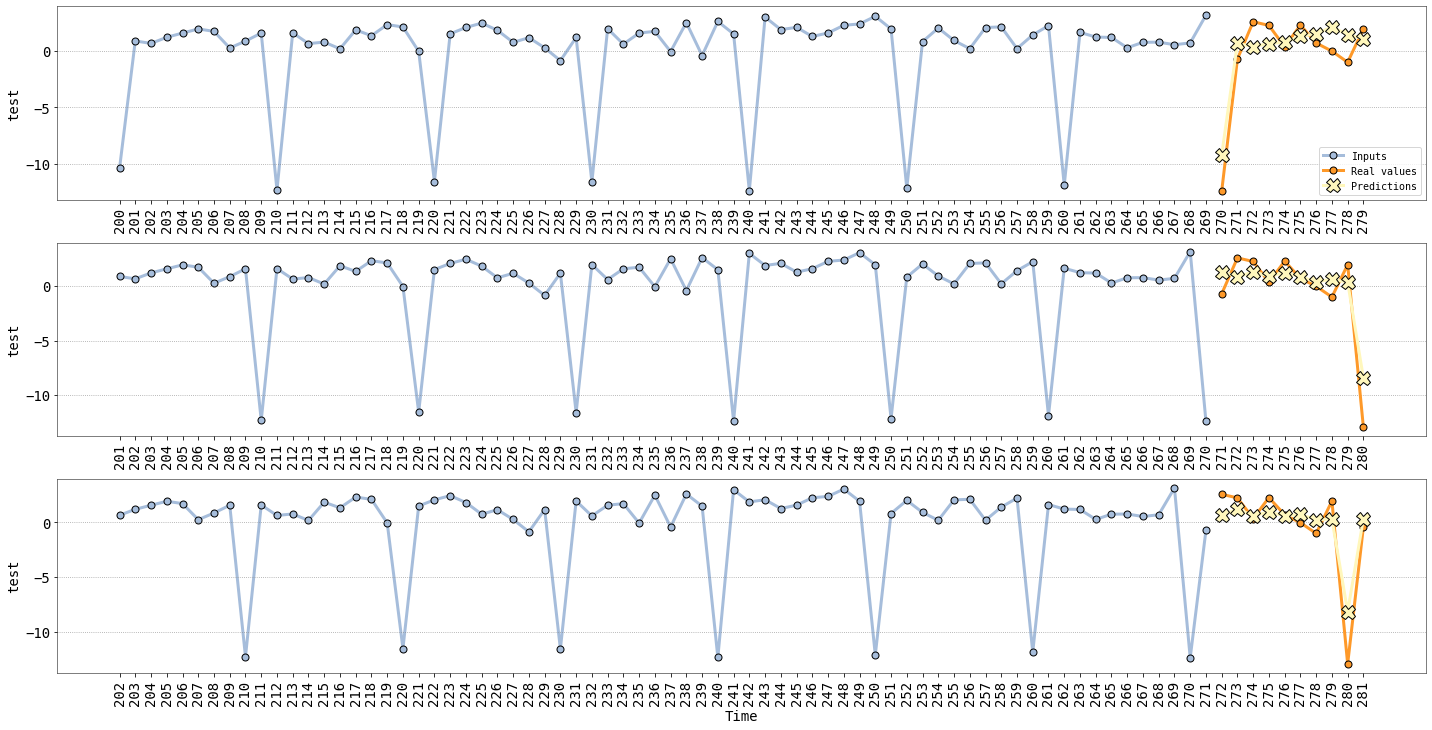

In [64]:
plotter = ShowTs(w, 'test', model)

plotter.plot_from_index('270', 'test')

In [65]:
model.evaluate(w.test)

2/2 [==============================] - 0s 132ms/step - loss: 123.1906 - output_1_loss: 11.1422 - output_2_loss: 4.3542 - output_3_loss: 13.1877 - output_4_loss: 12.4372 - output_5_loss: 7.9626 - output_6_loss: 10.2749 - output_7_loss: 4.3357 - output_8_loss: 9.0422 - output_9_loss: 1.8014 - output_10_loss: 5.8561 - output_11_loss: 9.9109 - output_12_loss: 2.3482 - output_13_loss: 2.2646 - output_14_loss: 4.5054 - output_15_loss: 7.7372 - output_16_loss: 6.8192 - output_17_loss: 2.7294 - output_18_loss: 6.4817 - output_1_mae: 2.3391 - output_2_mae: 1.5587 - output_3_mae: 2.3836 - output_4_mae: 2.2485 - output_5_mae: 1.9518 - output_6_mae: 2.2058 - output_7_mae: 1.4126 - output_8_mae: 2.0297 - output_9_mae: 1.0794 - output_10_mae: 1.6701 - output_11_mae: 2.1190 - output_12_mae: 1.1616 - output_13_mae: 1.1184 - output_14_mae: 1.4114 - output_15_mae: 1.8010 - output_16_mae: 1.8213 - output_17_mae: 1.2496 - output_18_mae: 1.6931


[123.19060516357422,
 11.142220497131348,
 4.3541693687438965,
 13.187655448913574,
 12.437155723571777,
 7.962591171264648,
 10.274881362915039,
 4.335674285888672,
 9.042177200317383,
 1.801416039466858,
 5.856063365936279,
 9.91093635559082,
 2.348227024078369,
 2.2646145820617676,
 4.505444049835205,
 7.737155914306641,
 6.8191819190979,
 2.729356288909912,
 6.481685638427734,
 2.3390891551971436,
 1.5586782693862915,
 2.3835537433624268,
 2.2484705448150635,
 1.951776385307312,
 2.205763816833496,
 1.4126057624816895,
 2.029683828353882,
 1.0794296264648438,
 1.6700966358184814,
 2.1190333366394043,
 1.1615511178970337,
 1.1183918714523315,
 1.4113855361938477,
 1.801042079925537,
 1.8213074207305908,
 1.2495630979537964,
 1.693149209022522]